In [1]:
import torch
import torch.nn as nn
import numpy as np

import torchvision
import torchvision.transforms as transforms
from PIL import Image
import os
from datetime import datetime
import sys
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

from omniglotDataset import OmniglotDataset
from models import LearnerConv

device = 'cuda:0'

In [2]:
Odset = OmniglotDataset(root='./', download=True)

== Found 32460 items 
== Found 1623 classes


In [3]:
Odset[100]

('./processed/images_background/Armenian/character03/0029_14.png', 5)

In [4]:
X_data = Odset.getOmniglotArray()

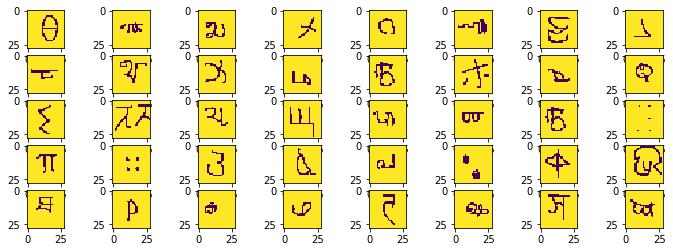

In [5]:
random_idx = np.random.randint(0, 1623, size=40)
img_samples = X_data[random_idx, 0, :, :]

fig = plt.figure(figsize=(12,4))
for i, img in enumerate(img_samples):
    ax  = fig.add_subplot(5, 8, i+1); 
    ax.imshow(img)

In [6]:
np.random.shuffle(X_data)
X_train = X_data[:1200,:,:,:]
X_test  = X_data[1200:,:,:,:]

print(f'train :{len(X_train)} | test:{len(X_test)}')

train :1200 | test:423


In [7]:
X_test = np.transpose(X_test, (1, 0, 2, 3))
X_test = shuffle(X_test, random_state=0)
X_test = np.transpose(X_test, (1, 0, 2, 3))
print(X_test.shape)

(423, 20, 28, 28)


#### Evaluate Omniglot MAML

In [8]:
def evaluateOmniglotMaml(num_tasks, num_points):
    
    if num_tasks == 5:
        omniglot_learner = LearnerConv(N_way=5, device=device)

        lr_b = 1e-4
        criterion = nn.NLLLoss(reduction='mean')
        optimizer = torch.optim.Adam(omniglot_learner.parameters(), lr=lr_b, betas=(0.9,0.999), eps=1e-08, weight_decay=0)
        optimizer.zero_grad()
        loadpath = "trained_models/omniglot_n5_k1_lr0.2_final.pth"
        omniglot_learner.load_state_dict(torch.load(loadpath, map_location='cuda:0'))    
        
    elif num_tasks == 20:
        omniglot_learner = LearnerConv(N_way=20, device=device)

        lr_b = 1e-4
        criterion = nn.NLLLoss(reduction='mean')
        optimizer = torch.optim.Adam(omniglot_learner.parameters(), lr=lr_b, betas=(0.9,0.999), eps=1e-08, weight_decay=0)
        optimizer.zero_grad()
        loadpath = "trained_models/omniglot_n20_k1_lr0.2_final.pth"
        omniglot_learner.load_state_dict(torch.load(loadpath, map_location='cuda:0'))            
        
    else:
        print('Invalid N-way parameter. N should be 5 or 20')
        return
    
    num_grad_update = 1  # for evaluation
    batch_size      = num_tasks*num_points
    lr_a            = 0.2

    eval_num_points = 20-num_points # each char has 20 instaces
    eval_batch_size = num_tasks * eval_num_points


    num_eval_char   = X_test.shape[0]
    num_iterations  = int(num_eval_char/num_tasks)

    criterion = nn.NLLLoss(reduction='mean')
    optimizer = torch.optim.SGD(omniglot_learner.parameters(), lr=lr_a, momentum=0.0)
    optimizer.zero_grad()

    idx = 0
    count_correct_pred = 0
    count_total_pred   = 0


    for iter in range(num_iterations):
        # 1. for task_i consisting of characters of [idx, idx+num_tasks)
        omniglot_learner.load_state_dict(torch.load(loadpath, map_location='cuda:0'))

        # 2. update the gradient 'num_grad_update' times
        X_batch = np.zeros((batch_size, 28, 28))
        Y_batch = np.zeros((batch_size))

        for k in range(num_tasks):
            X_batch[k*num_points:(k+1)*num_points,:,:] = X_test[idx+k,:num_points,:,:]
            Y_batch[k*num_points:(k+1)*num_points] = k

        X_batch = torch.tensor(X_batch, dtype=torch.float32).unsqueeze(1).to(device)
        Y_batch = torch.tensor(Y_batch, dtype=torch.long).to(device)

        for j in range(num_grad_update):
            # 2.2 compute gradient
            Y_pred = omniglot_learner(X_batch)

            loss = criterion(Y_pred, Y_batch)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

        # 3. evaluation
        X_batch_eval = np.zeros((eval_batch_size, 28, 28))
        Y_batch_eval = np.zeros((eval_batch_size))
        for k in range(num_tasks):
            X_batch_eval[k*eval_num_points:(k+1)*eval_num_points,:,:] = X_test[idx+k,num_points:,:,:]
            Y_batch_eval[k*eval_num_points:(k+1)*eval_num_points] = k

        X_batch_eval = torch.tensor(X_batch_eval, dtype=torch.float32).unsqueeze(1).to(device)
        Y_batch_eval = torch.tensor(Y_batch_eval, dtype=torch.long).to(device)

        Y_pred_eval = omniglot_learner(X_batch_eval)
        Y_pred_eval = Y_pred_eval.argmax(dim=-1)

        corr_pred  = (Y_batch_eval == Y_pred_eval).int().sum().item()
        total_pred = len(Y_batch_eval)
        count_correct_pred += corr_pred
        count_total_pred   += total_pred


        idx += num_tasks

    print("PREDICTION ACCURACY = {}".format(count_correct_pred/count_total_pred))


In [9]:
evaluateOmniglotMaml(5,1)

PREDICTION ACCURACY = 0.9575187969924812


In [10]:
evaluateOmniglotMaml(20,1)

PREDICTION ACCURACY = 0.9337092731829574
